In [36]:
import pandas as pd  # For data manipulation and analysis
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
from sklearn.ensemble import RandomForestClassifier  # Random Forest algorithm for classification
from sklearn.metrics import classification_report, roc_auc_score  # For model evaluation
from imblearn.over_sampling import SMOTE  # To handle class imbalance through oversampling
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier  # Gradient Boosting and Voting Classifier
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.metrics import accuracy_score  # To evaluate model accuracy
from sklearn.pipeline import Pipeline  # For building streamlined workflows
from sklearn.preprocessing import StandardScaler  # For feature scaling
import matplotlib.pyplot as plt  # For plotting and visualizations
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay  # Visualizations
import numpy as np  # For numerical operations
from sklearn.impute import SimpleImputer # For Imputing


# Load dataset
file_path = 'OKCupid_profiles.csv'  # Path to the dataset
okcupid_data = pd.read_csv(file_path)  # Read CSV file into a DataFrame

# Select relevant columns for the analysis
relevant_columns = ['diet', 'drinks', 'drugs', 'smokes', 'status']  # Columns of interest
okcupid_data_subset = okcupid_data[relevant_columns].copy()  # Create a subset of the data

# Map the `status` column to binary categories for classification
# Binary target: 'single' and 'available' are 0 (not in a relationship), 'seeing someone' and 'married' are 1
status_mapping = {
    'single': 0,
    'available': 0,  # Treating "available" as equivalent to "single"
    'seeing someone': 1,
    'married': 1,
    'unknown': None  # Treat "unknown" as missing values
}
okcupid_data_subset['status'] = okcupid_data_subset['status'].map(status_mapping)

# Fill missing values in the lifestyle-related columns with "unknown"
okcupid_data_subset.fillna({'diet': 'unknown', 'drinks': 'unknown', 
                            'drugs': 'unknown', 'smokes': 'unknown'}, inplace=True)

# Encode `drinks` with ordinal values based on frequency/intensity
drinks_mapping = {
    'not at all': 0,
    'rarely': 1,
    'socially': 2,
    'often': 3,
    'very often': 4,
    'desperately': 5,
    'unknown': -1  # Treat "unknown" with a special value
}
okcupid_data_subset.loc[:, 'drinks'] = okcupid_data_subset['drinks'].map(drinks_mapping)

# Encode `drugs` with ordinal values based on usage frequency
drugs_mapping = {
    'never': 0,
    'sometimes': 1,
    'often': 2,
    'unknown': -1  # Handle unknown values
}
okcupid_data_subset.loc[:, 'drugs'] = okcupid_data_subset['drugs'].map(drugs_mapping)

# Encode `smokes` with ordinal values based on usage
smokes_mapping = {
    'no': 0,
    'trying to quit': 1,
    'when drinking': 2,
    'sometimes': 3,
    'yes': 4,
    'unknown': -1  # Handle unknown values
}
okcupid_data_subset.loc[:, 'smokes'] = okcupid_data_subset['smokes'].map(smokes_mapping)

# Simplify and encode `diet` into a numerical format
# Assign specific categories, with "unknown" handled separately
diet_categories = {
    'vegetarian': 1, 'vegan': 2, 'kosher': 3, 'halal': 4, 'anything': 5,
    'other': 6, 'unknown': -1
}
okcupid_data_subset.loc[:, 'diet'] = okcupid_data_subset['diet'].apply(
    lambda x: diet_categories.get(next((key for key in diet_categories if key in str(x)), 'unknown'))
)

# Separate the features (X) and target (y)
X = okcupid_data_subset[['diet', 'drinks', 'drugs', 'smokes']]  # Feature matrix
y = okcupid_data_subset['status']  # Target variable

# Remove rows with missing target values
X = X[y.notnull()]  # Keep only rows where the target is not null
y = y[y.notnull()]

# Split data into training and testing sets
# Use stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the first few rows of the processed dataset
okcupid_data_subset.head()  # Preview to verify preprocessing

,diet,drinks,drugs,smokes,status
0,5,2,0,3,0.0
1,6,3,1,0,0.0
2,5,2,-1,0,0.0
3,1,2,-1,0,0.0
4,-1,2,0,0,0.0


In [20]:
# Use a simple logreg model to see if that is good at predicting

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('logreg', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))  # Logistic regression model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Generate the classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.54      0.69     11513
         1.0       0.05      0.62      0.10       475

    accuracy                           0.54     11988
   macro avg       0.51      0.58      0.40     11988
weighted avg       0.94      0.54      0.67     11988



In [22]:
logreg_accuracy = accuracy_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {logreg_accuracy * 100:.2f}%")

Logistic Regression Accuracy: 54.40%


In [4]:
print("\n=== Class Distribution ===")
print(y.value_counts(normalize=True) * 100)


=== Class Distribution ===
status
0.0    96.039108
1.0     3.960892
Name: proportion, dtype: float64


In [6]:
# Import SMOTE from imbalanced-learn for oversampling the minority class
# Here, a custom `sampling_strategy` is specified to adjust the class balance
# `sampling_strategy=0.7` means the minority class will be oversampled to reach 70% of the majority class
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_smote_new, y_smote_new = smote.fit_resample(X, y)  # Apply SMOTE to balance the classes

# Check the new class distribution after applying SMOTE
print("\n=== New Class Distribution ===")
print(y_smote_new.value_counts())  # Print the count of each class to verify the balance




=== New Class Distribution ===
status
0.0    57562
1.0    40293
Name: count, dtype: int64


In [7]:
# Split the resampled data into training and testing sets
# `stratify` ensures the class distribution in the splits mirrors the overall dataset
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_smote_new, y_smote_new, test_size=0.2, random_state=42, stratify=y_smote_new
)



In [8]:
# Baseline Accuracy
print(f"Baseline Accuracy: {max(y_smote_new.value_counts()) / len(y_smote_new) * 100:.2f}%")


Baseline Accuracy: 58.82%


In [9]:
# Define and train a Logistic Regression model using a pipeline
# The pipeline includes:
# 1. StandardScaler: Scales features to have zero mean and unit variance
# 2. LogisticRegression: Performs logistic regression with increased iterations (max_iter=1000) for convergence
logreg_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Feature scaling
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))  # Logistic regression model
])
logreg_pipeline.fit(X_train_new, y_train_new)  # Fit the pipeline to the training data
y_pred_logreg = logreg_pipeline.predict(X_test_new)  # Predict on the test set



In [10]:
# Evaluate all models
print("\n=== Logistic Regression Classification Report ===")
print(classification_report(y_test_new, y_pred_logreg))


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

         0.0       0.61      0.92      0.73     11512
         1.0       0.58      0.16      0.26      8059

    accuracy                           0.61     19571
   macro avg       0.59      0.54      0.49     19571
weighted avg       0.60      0.61      0.54     19571



In [11]:
# Define and train a Random Forest model
# Random Forest is an ensemble method that combines multiple decision trees
rf_model = RandomForestClassifier(random_state=42)  # Initialize with a random seed for reproducibility
rf_model.fit(X_train_new, y_train_new)  # Train the model on the new training set
y_pred_rf = rf_model.predict(X_test_new)  # Make predictions on the test set

logreg_accuracy = accuracy_score(y_test_new, y_pred_logreg)

print(f"Logistic Regression Accuracy: {logreg_accuracy * 100:.2f}%")


Logistic Regression Accuracy: 60.66%


In [12]:
# Define and train a Gradient Boosting model
# Gradient Boosting sequentially builds models to correct errors of previous models
gb_model = GradientBoostingClassifier(random_state=42)  # Initialize with a random seed for reproducibility
gb_model.fit(X_train_new, y_train_new)  # Train the model on the new training set
y_pred_gb = gb_model.predict(X_test_new)  # Make predictions on the test set


In [13]:
# Define and train a Voting Classifier
# Voting Classifier combines multiple models (logistic regression, random forest, and gradient boosting)
# The `voting='soft'` parameter averages the predicted probabilities from each model
voting_model = VotingClassifier(
    estimators=[
        ('logreg', logreg_pipeline),  # Logistic Regression pipeline
        ('random_forest', rf_model),  # Random Forest model
        ('gradient_boosting', gb_model)  # Gradient Boosting model
    ],
    voting='soft'  # Use probabilities for ensemble predictions
)
voting_model.fit(X_train_new, y_train_new)  # Train the ensemble model on the new training set
y_pred_voting = voting_model.predict(X_test_new)  # Make predictions on the test set

In [14]:
# Evaluate all models
print("\n=== Logistic Regression Classification Report ===")
print(classification_report(y_test_new, y_pred_logreg))

print("\n=== Random Forest Classification Report ===")
print(classification_report(y_test_new, y_pred_rf))

print("\n=== Gradient Boosting Classification Report ===")
print(classification_report(y_test_new, y_pred_gb))

print("\n=== Voting Classifier Classification Report ===")
print(classification_report(y_test_new, y_pred_voting))


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

         0.0       0.61      0.92      0.73     11512
         1.0       0.58      0.16      0.26      8059

    accuracy                           0.61     19571
   macro avg       0.59      0.54      0.49     19571
weighted avg       0.60      0.61      0.54     19571


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

         0.0       0.66      0.88      0.75     11512
         1.0       0.66      0.34      0.45      8059

    accuracy                           0.66     19571
   macro avg       0.66      0.61      0.60     19571
weighted avg       0.66      0.66      0.63     19571


=== Gradient Boosting Classification Report ===
              precision    recall  f1-score   support

         0.0       0.65      0.89      0.75     11512
         1.0       0.66      0.30      0.41      8059

    accuracy                         

In [15]:
# Compare accuracies
logreg_accuracy = accuracy_score(y_test_new, y_pred_logreg)
rf_accuracy = accuracy_score(y_test_new, y_pred_rf)
gb_accuracy = accuracy_score(y_test_new, y_pred_gb)
voting_accuracy = accuracy_score(y_test_new, y_pred_voting)

In [16]:
print("\n=== Accuracy Comparison with Custom SMOTE ===")
print(f"Baseline Accuracy: {max(y_smote_new.value_counts()) / len(y_smote_new) * 100:.2f}%")
print(f"Logistic Regression Accuracy: {logreg_accuracy * 100:.2f}%")
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print(f"Gradient Boosting Accuracy: {gb_accuracy * 100:.2f}%")
print(f"Voting Classifier Accuracy: {voting_accuracy * 100:.2f}%")


=== Accuracy Comparison with Custom SMOTE ===
Baseline Accuracy: 58.82%
Logistic Regression Accuracy: 60.66%
Random Forest Accuracy: 65.69%
Gradient Boosting Accuracy: 64.81%
Voting Classifier Accuracy: 65.79%


In [17]:
# Identify the best model
best_model = max(
    [('Logistic Regression', logreg_accuracy),
     ('Random Forest', rf_accuracy),
     ('Gradient Boosting', gb_accuracy),
     ('Voting Classifier', voting_accuracy)], 
    key=lambda x: x[1]
)

print(f"\nThe best model is: {best_model[0]} with an accuracy of {best_model[1] * 100:.2f}%")


The best model is: Voting Classifier with an accuracy of 65.79%


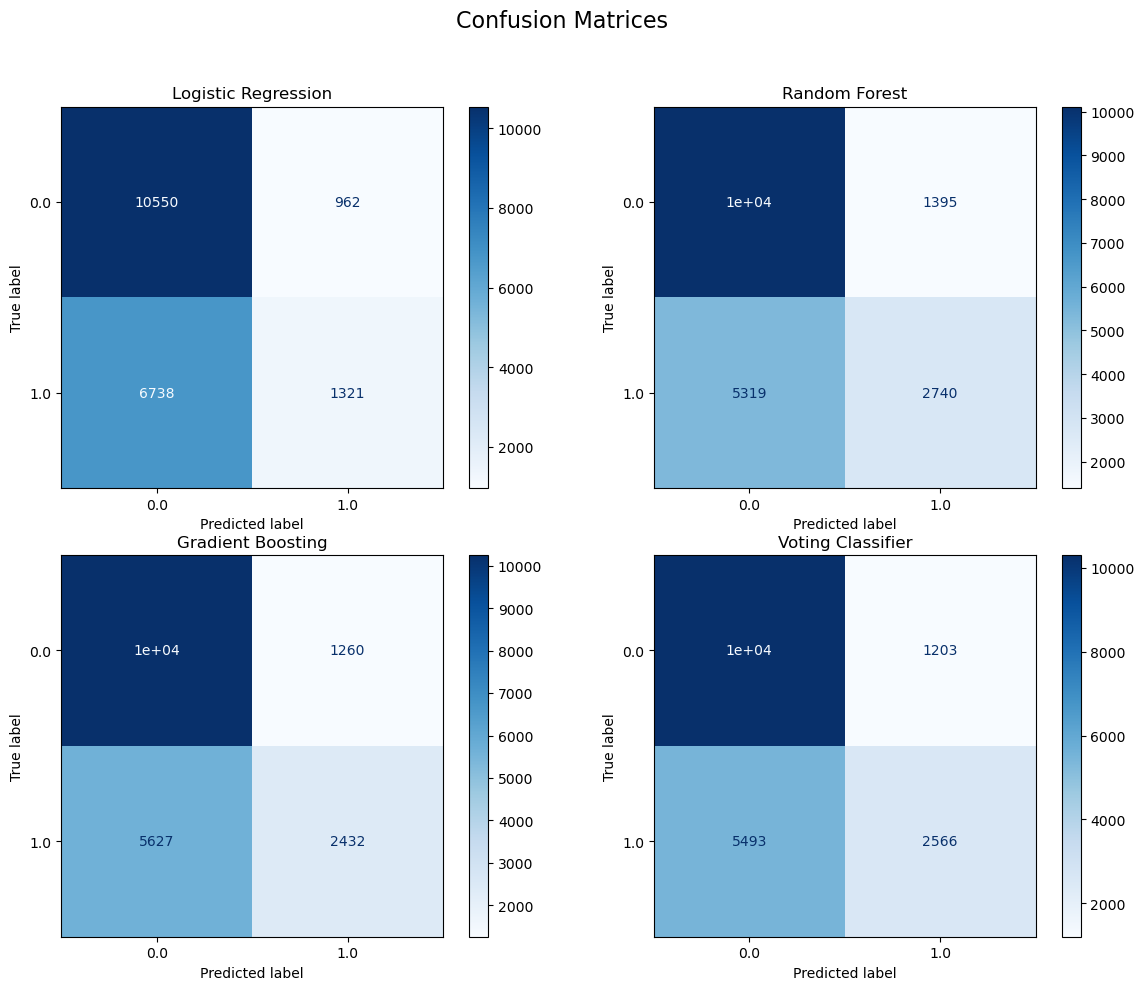

In [18]:
# 1. Confusion Matrix for each model

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Confusion Matrices", fontsize=16)

models = {
    "Logistic Regression": (y_test_new, y_pred_logreg),
    "Random Forest": (y_test_new, y_pred_rf),
    "Gradient Boosting": (y_test_new, y_pred_gb),
    "Voting Classifier": (y_test_new, y_pred_voting),
}

for ax, (model_name, (true, pred)) in zip(axes.ravel(), models.items()):
    ConfusionMatrixDisplay.from_predictions(true, pred, ax=ax, cmap="Blues")
    ax.title.set_text(model_name)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<Figure size 1000x800 with 0 Axes>

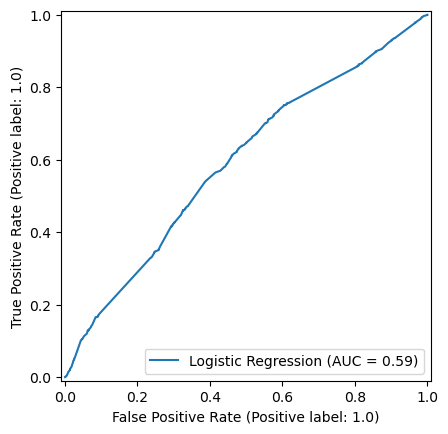

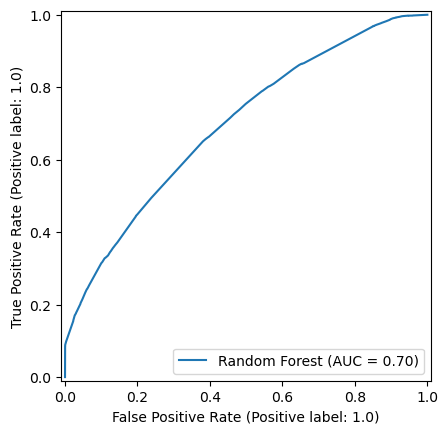

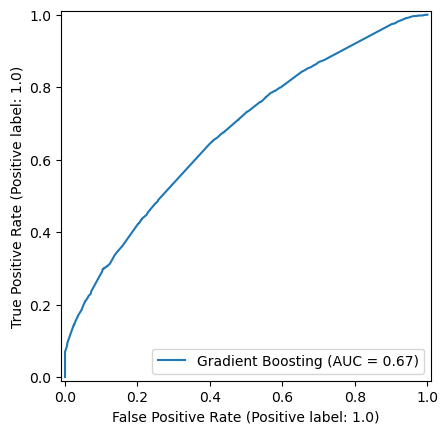

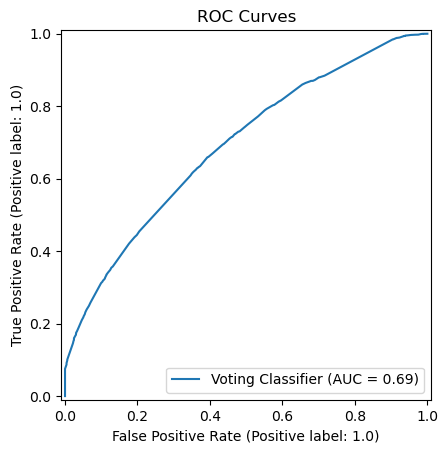

In [19]:
# 2. ROC Curves for all models

plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(logreg_pipeline, X_test_new, y_test_new, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf_model, X_test_new, y_test_new, name="Random Forest")
RocCurveDisplay.from_estimator(gb_model, X_test_new, y_test_new, name="Gradient Boosting")
RocCurveDisplay.from_estimator(voting_model, X_test_new, y_test_new, name="Voting Classifier")
plt.title("ROC Curves")
plt.show()

<Figure size 1000x800 with 0 Axes>

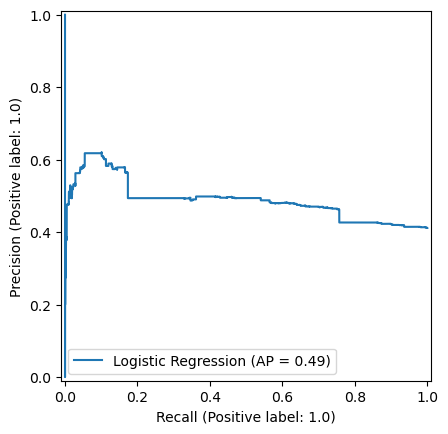

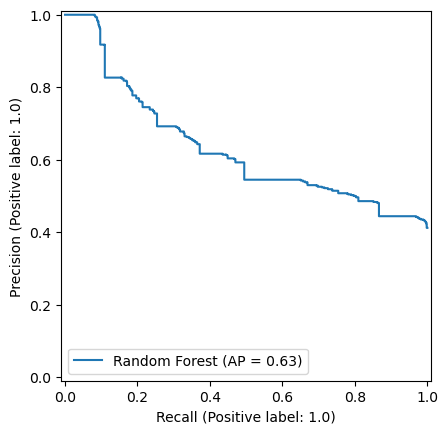

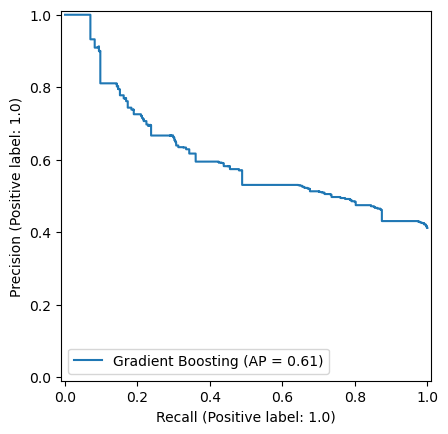

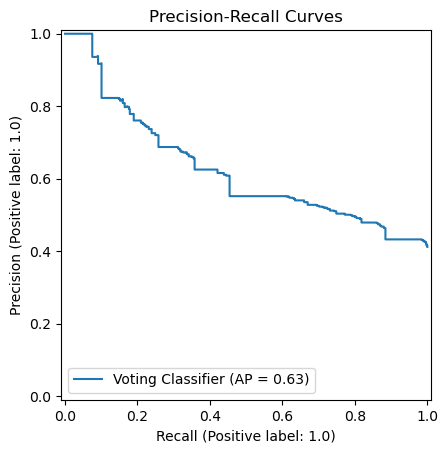

In [20]:
# 3. Precision-Recall Curves for all models

plt.figure(figsize=(10, 8))
PrecisionRecallDisplay.from_estimator(logreg_pipeline, X_test_new, y_test_new, name="Logistic Regression")
PrecisionRecallDisplay.from_estimator(rf_model, X_test_new, y_test_new, name="Random Forest")
PrecisionRecallDisplay.from_estimator(gb_model, X_test_new, y_test_new, name="Gradient Boosting")
PrecisionRecallDisplay.from_estimator(voting_model, X_test_new, y_test_new, name="Voting Classifier")
plt.title("Precision-Recall Curves")
plt.show()

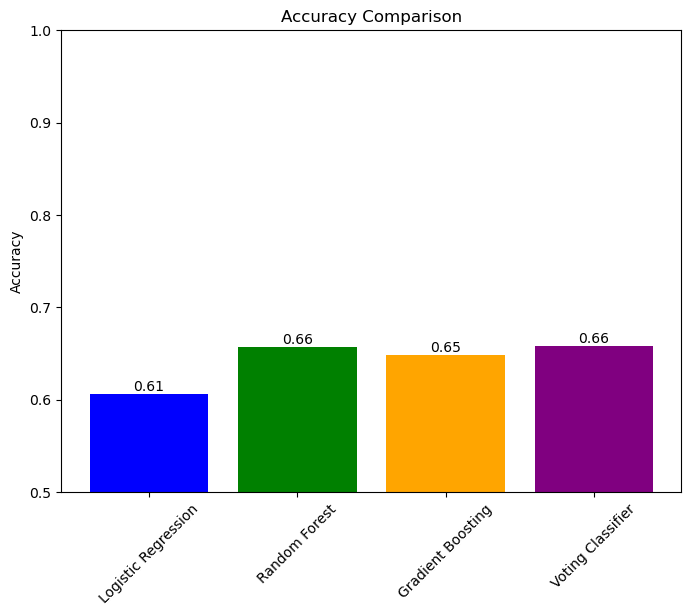

In [21]:
# 4. Bar chart comparing accuracy

models = ["Logistic Regression", "Random Forest", "Gradient Boosting", "Voting Classifier"]
accuracies = [logreg_accuracy, rf_accuracy, gb_accuracy, voting_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=["blue", "green", "orange", "purple"])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1)
plt.xticks(rotation=45)

for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha="center", va="bottom")
    
plt.show()

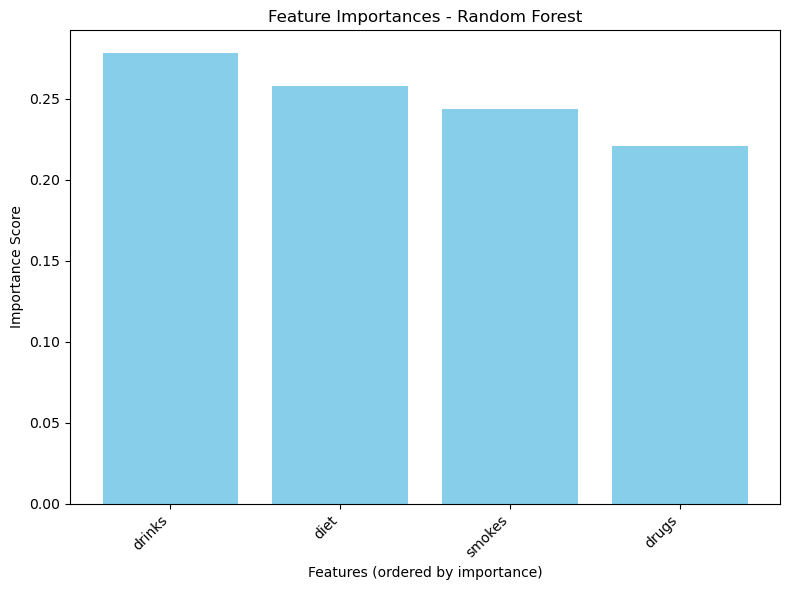

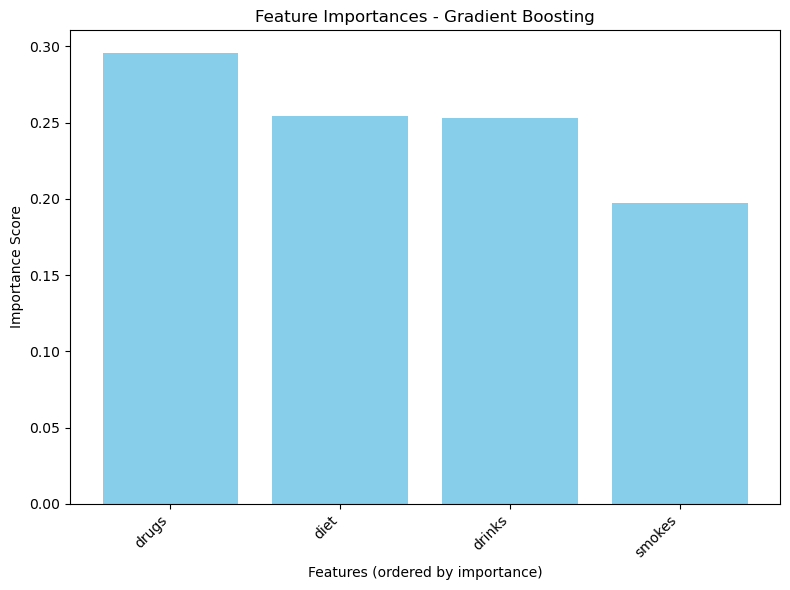

In [22]:
# 5. Feature importances for Random Forest and Gradient Boosting

models = [("Random Forest", rf_model), ("Gradient Boosting", gb_model)]
for name, model in models:
    plt.figure(figsize=(8, 6))
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], color="skyblue")
    plt.title(f"Feature Importances - {name}")
    plt.xlabel("Features (ordered by importance)")
    plt.ylabel("Importance Score")
    plt.xticks(range(len(feature_importances)), X.columns[sorted_idx], rotation=45, ha="right")
    plt.tight_layout()
    plt.show()